In [1]:
import nibabel as nib
import pandas as pd
import numpy as np

from average_conn_nc import correct_mean_var, build_size_roi, _simulate_img, _extract_time_series_voxel, _extract_time_series_parcels, _average_conn

# Intra-network average connectivity

We first get the mask of parcels

In [2]:
from nilearn import datasets
# Load MIST 64 atlas as mask
parcellation = datasets.fetch_atlas_basc_multiscale_2015(version='sym')['scale064']
img_mist = nib.load(parcellation)
img_mist.shape

(53, 64, 52)

Fetch a demo dataset

In [3]:
# Load a few brain development fmri datasets from nilearn
data = datasets.fetch_development_fmri(n_subjects=1, reduce_confounds=True)
imgs = data.func[0:10]
confounds = data.confounds[0:10]  # This is a preselected set of confounds

Build a group mask of fMRI brains for this mini-study. Let's start by generating brain masks from the fMRI time series. 

In [4]:
from nilearn.masking import compute_multi_epi_mask
mask_epi = compute_multi_epi_mask(imgs, lower_cutoff=0.2, upper_cutoff=0.85, connected=True, 
                       opening=2, threshold=0.5, target_affine=None, target_shape=None, 
                       exclude_zeros=False, n_jobs=1, memory=None, verbose=0)

/Users/natashaclarke/main_edu_conda/lib/python3.9/site-packages/nilearn/plotting/img_plotting.py:300: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()


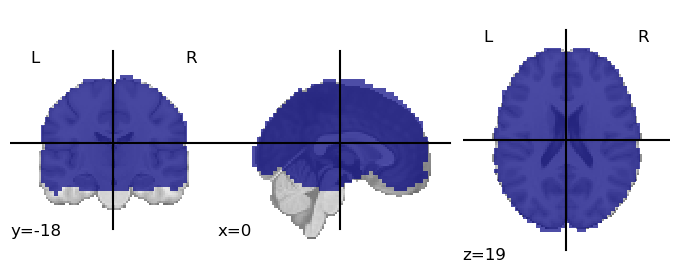

In [5]:
from nilearn.plotting import plot_roi
plot_roi(mask_epi, resampling_interpolation='nearest')

Now let's get a grey matter mask: 

In [6]:
from nilearn.datasets import fetch_icbm152_brain_gm_mask
from nilearn.image import resample_to_img
mask_mni = fetch_icbm152_brain_gm_mask()
mask_mni = resample_to_img(source_img=mask_mni, target_img=imgs[0], interpolation='nearest')

Let's visualize it

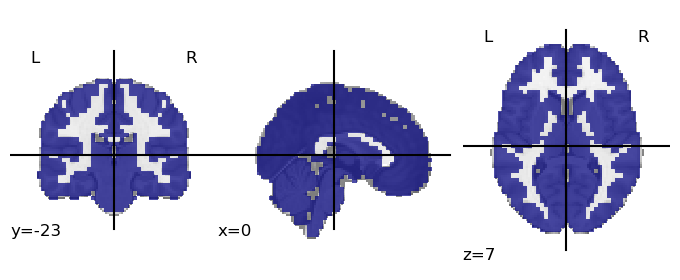

In [7]:
from nilearn.plotting import plot_roi
plot_roi(mask_mni, resampling_interpolation='nearest')

now we combine both masks into one:

In [8]:
from nilearn.image import math_img
mask_combined = math_img('img1 & img2', img1=mask_epi, img2=mask_mni)

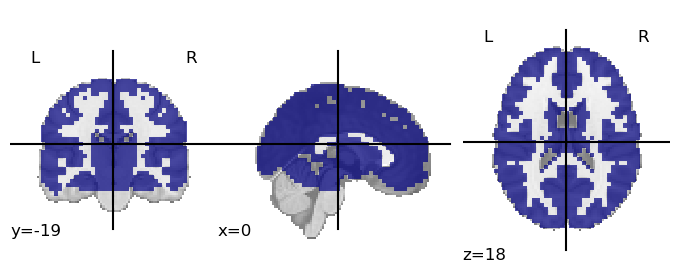

In [9]:
plot_roi(mask_combined, resampling_interpolation='nearest')

TODO: explore which MIST regions have small overlap with our mask, and possibly create a custom MIST atlas by excluding those regions 

We can now load voxel-wise data for one subject:

In [10]:
from nilearn.maskers import NiftiMasker
masker = NiftiMasker(standardize=True, mask_img=mask_combined, smoothing_fwhm=5,
                           memory='nilearn_cache', verbose=5)
time_series_voxel = masker.fit_transform(imgs[0], confounds=confounds[0])

[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask
[Memory]0.1s, 0.0min    : Loading resample_img...
________________________________________resample_img cache loaded - 0.0s, 0.0min
[Memory]0.2s, 0.0min    : Loading _filter_and_mask...
_____________________________________filter_and_mask cache loaded - 0.1s, 0.0min


We have standardized the voxel time series. We convert that back into 4D so we can apply the LabelsMasker on it. 

In [11]:
img_n = masker.inverse_transform(time_series_voxel)

[Memory]0.4s, 0.0min    : Loading unmask...
______________________________________________unmask cache loaded - 0.5s, 0.0min


before we do what comes next, we need to do gymnastics to ensure that we remove voxels in the mist template that are *not* in the grey matter template. No time for that here.


Extract the MIST atlas in the space of our grey matter mask:

In [12]:
from nilearn.image import resample_to_img
mist_resampled = resample_to_img(img_mist, mask_combined, interpolation='nearest')
masker_no_standardize = NiftiMasker(standardize=False, mask_img=mask_combined, 
                           memory='nilearn_cache', verbose=5)
mist_voxel = masker_no_standardize.fit_transform(mist_resampled)

[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask
[Memory]0.0s, 0.0min    : Loading resample_img...
________________________________________resample_img cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _filter_and_mask...
_____________________________________filter_and_mask cache loaded - 0.0s, 0.0min


Time to apply the LabelsMasker.

In [13]:
from nilearn.maskers import NiftiLabelsMasker
masker_mist = NiftiLabelsMasker(labels_img=mist_resampled, standardize=False,
                           memory='nilearn_cache', verbose=5)
time_series_mist = masker_mist.fit_transform(img_n)

[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(50, 59, 50),
affine=array([[   4.,    0.,    0.,  -96.],
       [   0.,    4.,    0., -132.],
       [   0.,    0.,    4.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[Memory]0.7s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


Let's observe the variance of the time series. Those are directly related to the AFC of the parcels, although they need to be controlled for the size of parcels. 

In [14]:
np.var(time_series_mist, axis=0)

array([0.07189103, 0.12811036, 0.03420185, 0.05506778, 0.        ,
       0.02342861, 0.17162246, 0.04550914, 0.00425407, 0.15318133,
       0.        , 0.0033628 , 0.07158569, 0.08979335, 0.        ,
       0.11121712, 0.10970106, 0.09104467, 0.14820679, 0.17394102,
       0.07931476, 0.00580568, 0.13794761, 0.04471486, 0.03131744,
       0.06162408, 0.12290025, 0.08006804, 0.00158666, 0.18680593,
       0.18172388, 0.11704294, 0.36357799, 0.12457719, 0.21862329,
       0.03547169, 0.16713906, 0.17946227, 0.05937302, 0.16940867,
       0.02960388, 0.07942073, 0.14905921, 0.        , 0.04701981,
       0.10120652, 0.10760563, 0.        , 0.14838123, 0.05840484,
       0.12042625, 0.08669737, 0.11630356, 0.0736085 , 0.05890693,
       0.07270342, 0.08549519, 0.10115371, 0.1742073 , 0.05906836,
       0.06731174, 0.10887669, 0.0850548 , 0.09072561])

Finally we derive AFC using the same formula as in NIAK:

In [15]:
var_mist = time_series_mist.var(axis=0) 
var_mist = np.reshape(var_mist, [var_mist.shape[0], 1])
size_parcels = build_size_roi(mist_voxel, masker_mist.labels_)
mask_empty = (size_parcels == 0) | (size_parcels == 1)
afc = ((size_parcels * size_parcels) * var_mist - size_parcels) / (size_parcels * (size_parcels - 1))
afc[mask_empty] = 0

/var/folders/dt/mwxrt1s120l7rg9b1ty2pc540000gn/T/ipykernel_18595/768959765.py:5: RuntimeWarning: invalid value encountered in true_divide
  afc = ((size_parcels * size_parcels) * var_mist - size_parcels) / (size_parcels * (size_parcels - 1))


In [16]:
size_parcels[0]

array([323.])

In [17]:
num_parcel = 1
print(f"parcel number {num_parcel}, average connectivity {afc[num_parcel - 1]}, size {size_parcels[num_parcel - 1]}")

parcel number 1, average connectivity [0.0690087], size [323.]


In [18]:
# Extract the voxel time series in the first network
time_series_network = time_series_voxel[:, mist_voxel[0, :]==num_parcel]
time_series_network.shape

(168, 323)

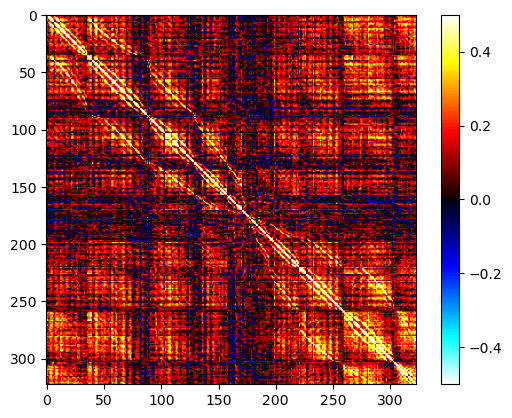

In [19]:
import matplotlib.pyplot as plt
conn_network = np.corrcoef(time_series_network.transpose())
plt.imshow(conn_network, vmin=-0.5, vmax=0.5, cmap='cold_hot')
plt.colorbar()

In [20]:
np.mean(conn_network[np.tril(np.ones(conn_network.shape), -1)==1])

0.10419664303550362

# Test the software

Let's simulate some data with one "spot". Note, time series are random so 'corr' will change!

In [21]:
img, mask, corr = _simulate_img()

In [22]:
corr

0.6780853709623729

## Step 1: Let's compute AFC brute force

In [23]:
time_series_voxel, masker_voxel = _extract_time_series_voxel(img, mask)

In [24]:
assert abs(np.corrcoef(time_series_voxel.transpose())[1, 0] - corr) < 1e-10

## Step 2: use the super complicated method

Using a little function to compute AFC, to make life easier.

In [25]:
time_series_parcels, masker_parcels, parcels_voxel = _extract_time_series_parcels(img, mask, mask)
assert np.abs(np.var(time_series_parcels) - (1 + 1 + 2 * corr) / 4) < 1e-10

In [26]:
afc_test = _average_conn(img, mask, mask)
assert np.abs(corr - afc) < 1e-10

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
afc_test

## It works, bar rounding differences!

# Now we compute the connectome and add the afc as the diagonal

Compute connectome

In [ ]:
corr_measure = ConnectivityMeasure(kind="correlation")
connectome = corr_measure.fit_transform([time_series_mist])[0]
connectome.shape

Get the indices of the diagonal

In [ ]:
diagonal = np.diag_indices_from(connectome)

Flatten the afc array

In [ ]:
afc_flat = afc.flatten()
afc_flat.shape

And replace the connectome diagonal with the afc values

In [ ]:
connectome[diagonal] = afc_flat
connectome

## Finally, we fisher-z transform the connectome values, to match NIAK

In [ ]:
connectome_fisher = np.arctanh(connectome) 

Convert to a dataframe

In [ ]:
connectome_df = pd.DataFrame(connectome_fisher, columns=masker_mist.labels_, index=masker_mist.labels_)
connectome_df.head()

And save!

In [ ]:
from pathlib import Path
connectome_df.to_csv(Path("__file__").resolve().parents[1] / 'data' / 'connectome.csv')

# Something weird going on with some regions?